In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
from matplotlib.patches import Patch
from skimage.draw import polygon2mask
from skimage.draw import line
from scipy.ndimage import center_of_mass

def load_dicom_series_to_hu(dicom_dir):
    slices = []
    for s in os.listdir(dicom_dir):
        try:
            filepath = os.path.join(dicom_dir, s)
            ds = pydicom.dcmread(filepath)
            if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.2' and 'PixelData' in ds:
                slices.append(ds)
        except Exception:
            continue
    if not slices:
        print(f"No valid CT DICOM images found in {dicom_dir}")
        return None, None
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    pixel_spacing = slices[0].PixelSpacing
    slice_thickness = float(slices[0].SliceThickness)
    spacing_between_slices = getattr(slices[0], 'SpacingBetweenSlices', slice_thickness)
    image_position_patient = np.array(slices[0].ImagePositionPatient)
    origin_3d = image_position_patient
    spacing_3d = np.array([pixel_spacing[1], pixel_spacing[0], spacing_between_slices])
    image_3d_shape = (len(slices), slices[0].Rows, slices[0].Columns)
    image_3d_hu = np.zeros(image_3d_shape, dtype=np.int16)
    for i, s in enumerate(slices):
        raw_pixel_array = s.pixel_array
        rescale_slope = getattr(s, 'RescaleSlope', 1)
        rescale_intercept = getattr(s, 'RescaleIntercept', 0)
        hu_array = raw_pixel_array * rescale_slope + rescale_intercept
        image_3d_hu[i, :, :] = hu_array
    slice_z_positions = np.array([float(s.ImagePositionPatient[2]) for s in slices])
    return image_3d_hu, {
        'origin': origin_3d,
        'spacing': spacing_3d,
        'shape': image_3d_hu.shape,
        'slice_z_positions': slice_z_positions,
        'slice_thickness': slice_thickness
    }

def create_metal_mask_from_rtstruct(rtstruct_path, ct_spatial_meta, slice_index, implant_roi_names):
    """
    Creates a boolean mask for a specific slice from an RTSTRUCT file using pydicom.

    Args:
        rtstruct_path (str): Path to the DICOM RTSTRUCT file.
        ct_spatial_meta (dict): The spatial metadata from your loading function.
        slice_index (int): The index of the slice to generate the mask for.
        implant_roi_names (list of str): A list of possible names for the implant contours.

    Returns:
        np.ndarray: A 2D boolean numpy array representing the combined mask, or None.
    """
    # --- 1. Load the RTSTRUCT file and get spatial info ---
    rtstruct = pydicom.dcmread(rtstruct_path)
    slice_z_pos = ct_spatial_meta['slice_z_positions'][slice_index]
    slice_shape = (ct_spatial_meta['shape'][1], ct_spatial_meta['shape'][2])
    origin = ct_spatial_meta['origin']
    spacing = ct_spatial_meta['spacing']

    combined_mask = np.zeros(slice_shape, dtype=bool)

    # --- 2. Find the ROI Number(s) corresponding to your implant names ---
    roi_numbers = []
    for roi in rtstruct.StructureSetROISequence:
        if any(name.lower() in roi.ROIName.lower() for name in implant_roi_names):
            roi_numbers.append(roi.ROINumber)

    if not roi_numbers:
        print(f"Warning: No contours found with names matching {implant_roi_names}")
        return None

    # --- 3. Loop through all contours and find the ones matching your ROI number(s) ---
    for roi_contour in rtstruct.ROIContourSequence:
        if roi_contour.ReferencedROINumber in roi_numbers:
            # This check is necessary because a contour sequence can be empty
            if not hasattr(roi_contour, 'ContourSequence'):
                continue
            
            # --- 4. Loop through each contour slice (e.g., for different Z positions) ---
            for contour_slice in roi_contour.ContourSequence:
                contour_data = np.array(contour_slice.ContourData).reshape(-1, 3)
                contour_z = contour_data[0, 2] # Z position of this contour slice

                # --- 5. Check if the contour is on the CT slice we are analyzing ---
                if np.isclose(contour_z, slice_z_pos):
                    # Convert world coordinates (mm) to pixel coordinates
                    pixel_coords = contour_data[:, :2]
                    pixel_coords[:, 0] = (pixel_coords[:, 0] - origin[0]) / spacing[1] # X -> col
                    pixel_coords[:, 1] = (pixel_coords[:, 1] - origin[1]) / spacing[0] # Y -> row
                    pixel_coords = pixel_coords[:, [1, 0]] # Swap to (row, col)

                    # Create a mask from the polygon and merge it with the main mask
                    poly_mask = polygon2mask(slice_shape, pixel_coords)
                    combined_mask |= poly_mask

    if not np.any(combined_mask):
        print(f"Warning: Matching contours were found, but none were on slice {slice_index} (Z={slice_z_pos:.2f}mm)")
        return None

    return combined_mask

In [3]:
def get_star_profile_values(current_slice, metal_mask, roi_boundaries):
    """
    Performs the 16-point star profile analysis and returns all HU values,
    IGNORING any pixels that are part of the metal mask itself.
    """
    # --- Find the center of the metal implant using center of mass ---
    try:
        r_center, c_center = center_of_mass(metal_mask)
        r_center, c_center = int(r_center), int(c_center)
    except Exception as e:
        print(f"Warning: Center of mass calculation failed ({e}). Falling back to bounding box center.")
        r_coords, c_coords = np.where(metal_mask)
        r_center = int(np.mean([np.min(r_coords), np.max(r_coords)]))
        c_center = int(np.mean([np.min(c_coords), np.max(c_coords)]))

    # --- Use the provided ROI boundaries ---
    r_min_roi, r_max_roi, c_min_roi, c_max_roi = roi_boundaries

    # --- Define the 16 endpoints for the star ---
    r_mid = int((r_min_roi + r_max_roi) / 2)
    c_mid = int((c_min_roi + c_max_roi) / 2)
    endpoints = [
        (r_min_roi, c_min_roi), (r_min_roi, c_max_roi), (r_max_roi, c_min_roi), (r_max_roi, c_max_roi),
        (r_min_roi, c_mid), (r_max_roi, c_mid), (r_mid, c_min_roi), (r_mid, c_max_roi),
        (r_min_roi, int((c_min_roi + c_mid) / 2)), (r_min_roi, int((c_max_roi + c_mid) / 2)),
        (r_max_roi, int((c_min_roi + c_mid) / 2)), (r_max_roi, int((c_max_roi + c_mid) / 2)),
        (int((r_min_roi + r_mid) / 2), c_min_roi), (int((r_max_roi + r_mid) / 2), c_min_roi),
        (int((r_min_roi + r_mid) / 2), c_max_roi), (int((r_max_roi + r_mid) / 2), c_max_roi)
    ]

    # --- Extract HU values along each of the 16 lines ---
    all_profile_values = []
    for r_end, c_end in endpoints:
        rr, cc = line(r_center, c_center, r_end, c_end)

        # --- NEW: Filter out pixels that are part of the metal mask ---
        # Get the mask values along the line
        is_metal = metal_mask[rr, cc]
        # Keep only the coordinates where the mask is False (not metal)
        non_metal_rr = rr[~is_metal]
        non_metal_cc = cc[~is_metal]
        
        # Get the HU values for only the non-metal pixels
        all_profile_values.append(current_slice[non_metal_rr, non_metal_cc])

    return np.concatenate(all_profile_values)

In [4]:
def find_dark_artifact_range_automatically(current_slice, metal_mask, roi_boundaries):
    """
    Analyzes star-profile values to automatically determine the HU range for dark artifacts.
    """
    # Get all profile values using the new helper function
    profile_values = get_star_profile_values(current_slice, metal_mask, roi_boundaries)

    # Analyze the profile values to find the dark artifact range
    potential_dark_values = profile_values[profile_values < -100]

    if potential_dark_values.size < 20:
        print("Warning: Not enough dark pixel samples found to determine range automatically.")
        return None

    min_hu = np.min(potential_dark_values)
    max_hu = np.percentile(potential_dark_values, 75) # Using 75th percentile as requested

    if min_hu >= max_hu:
        return None

    return (int(min_hu), int(max_hu))

def find_bright_artifact_range_automatically(current_slice, metal_mask, roi_boundaries):
    """
    Analyzes star-profile values to automatically determine the HU range for
    high-HU bright artifacts around the metal implant.

    Returns:
        list: A list containing one (min_hu, max_hu) tuple, or None.
    """
    # Get all profile values using the helper function
    profile_values = get_star_profile_values(current_slice, metal_mask, roi_boundaries)

    # Analyze the profile values to find the bright artifact range
    # We assume bright artifacts are significantly above normal tissue/bone values.
    potential_bright_values = profile_values[profile_values > 800]

    if potential_bright_values.size < 20:
        print("Warning: Not enough bright pixel samples found to determine range automatically.")
        return None

    # Use percentiles to define a robust range
    min_hu = np.percentile(potential_bright_values, 25)
    max_hu = np.percentile(potential_bright_values, 90)

    # Sanity check: ensure the range is valid and doesn't go into extreme metal values
    if min_hu >= max_hu or min_hu > 3000:
        return None

    # Return as a list of tuples to match the format of the original manual range
    return [(int(min_hu), int(max_hu))]

In [5]:
# --- NEW HELPER FUNCTION: Plot IVH for a single region ---
def plot_single_slice_ivh(hu_values, region_name, color='blue'):
    """
    Plots a histogram for a specific region's HU values from a single slice.
    """
    if hu_values.size == 0:
        print(f"No HU values to plot for {region_name}.")
        return

    plt.figure(figsize=(7, 5))
    
    # Define bin range to cover typical CT values, potentially extending for metal/artifacts
    min_hu_plot = -1024
    max_hu_plot = 5000 # Extend to capture higher artifact/metal values
    
    # Use a fixed number of bins for consistency
    bins = np.linspace(min_hu_plot, max_hu_plot, 100)

    plt.hist(hu_values, bins=bins, color=color, edgecolor='black', alpha=0.7)
    plt.title(f"IVH for {region_name} (Single Slice)", fontsize=14)
    plt.xlabel('Hounsfield Unit (HU)', fontsize=12)
    plt.ylabel('Frequency (Number of Pixels)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [6]:
def visualize_implant_artifacts_and_tissues(
    ct_hu_volume,
    slice_index,
    metal_mask,
    bright_artifact_hu_ranges, # Serves as a fallback
    bone_hu_range,
    artifact_roi_margin_pixels,
    dark_artifact_hu_range=(-1000, -250),
    auto_find_dark_range=False,
    auto_find_bright_range=False # <-- NEW PARAMETER
):
    """
    Identifies and visually displays metal, bright artifacts, bone, and dark artifacts
    on a given CT slice. Artifacts are constrained to an ROI around metal.
    Also generates IVHs for each characterized region on this single slice.
    """
    if slice_index < 0 or slice_index >= ct_hu_volume.shape[0]:
        print(f"Error: Slice index {slice_index} is out of bounds for volume with {ct_hu_volume.shape[0]} slices.")
        return

    current_slice = ct_hu_volume[slice_index, :, :]
    rows, cols = current_slice.shape

    # --- Characterization Logic ---

    # 1. Check for a valid metal mask
    if metal_mask is None or not np.any(metal_mask):
        print(f"No valid metal mask provided or found for slice {slice_index}. "
              "Cannot define artifact ROI and proceed with detailed characterization.")
        plt.figure(figsize=(6,6))
        plt.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
        plt.title(f"CT Slice {slice_index} (No Metal or Overlays)")
        plt.axis('off')
        plt.show()
        return

    # Find bounding box of the metal to define the ROI around it
    r_coords, c_coords = np.where(metal_mask)
    r_min_metal, r_max_metal = np.min(r_coords), np.max(r_coords)
    c_min_metal, c_max_metal = np.min(c_coords), np.max(c_coords)

    # Define the ROI boundaries
    r_min_roi = max(0, r_min_metal - artifact_roi_margin_pixels)
    r_max_roi = min(rows, r_max_metal + artifact_roi_margin_pixels)
    c_min_roi = max(0, c_min_metal - artifact_roi_margin_pixels)
    c_max_roi = min(cols, c_max_metal + artifact_roi_margin_pixels)

    roi_boundaries = (r_min_roi, r_max_roi, c_min_roi, c_max_roi)

    # --- Automatically find dark artifact range if requested ---
    if auto_find_dark_range:
        print("\n--- Attempting to automatically find dark artifact HU range ---")
        roi_boundaries = (r_min_roi, r_max_roi, c_min_roi, c_max_roi)
        auto_dark_range = find_dark_artifact_range_automatically(
            current_slice, metal_mask, roi_boundaries
        )
        if auto_dark_range:
            dark_artifact_hu_range = auto_dark_range
            print(f"Automatically determined dark artifact range: {dark_artifact_hu_range}")
        else:
            print("Could not automatically determine range. Using fallback/default range.")
            
      # --- NEW: Automatically find bright artifact range if requested ---
    if auto_find_bright_range:
        print("\n--- Attempting to automatically find bright artifact HU range ---")
        auto_bright_range = find_bright_artifact_range_automatically(
            current_slice, metal_mask, roi_boundaries
        )
        if auto_bright_range:
            bright_artifact_hu_ranges = auto_bright_range
            print(f"Automatically determined bright artifact range: {bright_artifact_hu_ranges}")
        else:
            print("Could not automatically determine range. Using fallback/default range.")

    # 2. Characterize Dark Artifacts (we now need to create the ROI mask here)
    artifact_roi_mask = np.zeros(current_slice.shape, dtype=bool)
    artifact_roi_mask[r_min_roi:r_max_roi, c_min_roi:c_max_roi] = True
    
    min_hu_dark, max_hu_dark = dark_artifact_hu_range
    dark_artifact_hu_mask_raw = (current_slice >= min_hu_dark) & (current_slice <= max_hu_dark)
    final_dark_artifact_mask = dark_artifact_hu_mask_raw & artifact_roi_mask
    dark_artifact_hu_values = current_slice[final_dark_artifact_mask]
    
    if np.any(final_dark_artifact_mask):
        print(f"Dark Artifacts found: Count={dark_artifact_hu_values.size}, Min HU={dark_artifact_hu_values.min():.2f}, Max HU={dark_artifact_hu_values.max():.2f}")
    else:
        print("No dark artifact pixels found in the defined ROI and HU range.")

    # 3. Characterize Bright Artifacts (within the artifact_roi_mask, EXCLUDING metal)
    print("\n--- Characterizing Bright Artifacts ---")
    bright_artifact_hu_mask_combined = np.zeros_like(current_slice, dtype=bool)
    for i, (min_hu_bright, max_hu_bright) in enumerate(bright_artifact_hu_ranges):
        bright_artifact_hu_mask_range = (current_slice >= min_hu_bright) & (current_slice <= max_hu_bright)
        bright_artifact_hu_mask_combined |= bright_artifact_hu_mask_range
        print(f"  Step 1.{(i+1)} (Raw HU range {min_hu_bright}-{max_hu_bright}): {np.sum(bright_artifact_hu_mask_range)} pixels identified.")
    
    bright_artifact_in_roi_mask = bright_artifact_hu_mask_combined & artifact_roi_mask
    final_bright_artifact_mask = bright_artifact_in_roi_mask & ~metal_mask
    bright_artifact_hu_values = current_slice[final_bright_artifact_mask]
    if np.any(final_bright_artifact_mask):
        print(f"Bright Artifacts found: Count={bright_artifact_hu_values.size}, Min HU={bright_artifact_hu_values.min():.2f}, Max HU={bright_artifact_hu_values.max():.2f}")
    else:
        print("No bright artifact pixels found after all filtering.")

    # 4. Characterize Bone (within the artifact_roi_mask, EXCLUDING metal and bright artifacts)
    min_hu_bone, max_hu_bone = bone_hu_range
    bone_hu_mask_raw = (current_slice >= min_hu_bone) & (current_slice <= max_hu_bone)
    final_bone_mask = bone_hu_mask_raw & artifact_roi_mask & ~metal_mask & ~final_bright_artifact_mask
    bone_hu_values = current_slice[final_bone_mask]
    if np.any(final_bone_mask):
        print(f"Bone found: Count={bone_hu_values.size}, Min HU={bone_hu_values.min():.2f}, Max HU={bone_hu_values.max():.2f}")
    else:
        print("No bone pixels found in the defined ROI and HU range.")
    
    # Extract metal HU values
    metal_hu_values = current_slice[metal_mask]
    if np.any(metal_mask):
        print(f"Metal Implant found: Count={metal_hu_values.size}, Min HU={metal_hu_values.min():.2f}, Max HU={metal_hu_values.max():.2f}")
    else:
        print("No metal pixels found.")

    # --- Visualization of Overlays ---
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    ax.imshow(current_slice, cmap='gray', vmin=-150, vmax=250) 
    ax.set_title(f"CT Slice {slice_index} with Characterized Regions")
    ax.axis('off')

    # Define specific RGBA colors for each category
    metal_rgba = (1.0, 0.0, 0.0, 0.7)          # Red
    bright_artifact_rgba = (1.0, 1.0, 0.0, 0.6) # Yellow
    dark_artifact_rgba = (1.0, 0.0, 1.0, 0.6)   # Magenta
    bone_rgba = (0.0, 0.2, 0.8, 0.5)            # Dark Blue
    roi_boundary_color = 'lime'

    # Overlay masks
    if np.any(metal_mask):
        metal_overlay = np.zeros((*current_slice.shape, 4)) 
        metal_overlay[metal_mask] = metal_rgba 
        ax.imshow(metal_overlay) 

    if np.any(final_bright_artifact_mask):
        bright_overlay = np.zeros((*current_slice.shape, 4))
        bright_overlay[final_bright_artifact_mask] = bright_artifact_rgba
        ax.imshow(bright_overlay)

    if np.any(final_bone_mask):
        bone_overlay = np.zeros((*current_slice.shape, 4))
        bone_overlay[final_bone_mask] = bone_rgba
        ax.imshow(bone_overlay)

    if np.any(final_dark_artifact_mask):
        dark_overlay = np.zeros((*current_slice.shape, 4))
        dark_overlay[final_dark_artifact_mask] = dark_artifact_rgba
        ax.imshow(dark_overlay)

    # Draw the automatically defined ROI boundary
    ax.add_patch(plt.Rectangle((c_min_roi, r_min_roi), c_max_roi-c_min_roi, r_max_roi-r_min_roi,
                                 edgecolor=roi_boundary_color, facecolor='none', linewidth=2, linestyle='--', label='Auto ROI'))
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor=metal_rgba, edgecolor='black', label='Metal Implant'),
        Patch(facecolor=bright_artifact_rgba, edgecolor='black', label='Bright Artifacts'),
        Patch(facecolor=bone_rgba, edgecolor='black', label='Bone'),
        Patch(facecolor=dark_artifact_rgba, edgecolor='black', label='Dark Artifacts'),
        Patch(facecolor='none', edgecolor=roi_boundary_color, lw=2, ls='--', label='Auto ROI')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

    # --- Generate and Display IVHs for each region on this slice ---
    print("\n--- Generating IVHs for each characterized region on this slice ---")
    plot_single_slice_ivh(metal_hu_values, "Metal Implant", color=(metal_rgba[0], metal_rgba[1], metal_rgba[2]))
    plot_single_slice_ivh(bright_artifact_hu_values, "Bright Artifacts", color=(bright_artifact_rgba[0], bright_artifact_rgba[1], bright_artifact_rgba[2]))
    plot_single_slice_ivh(bone_hu_values, "Bone", color=(bone_rgba[0], bone_rgba[1], bone_rgba[2]))
    plot_single_slice_ivh(dark_artifact_hu_values, "Dark Artifacts", color=(dark_artifact_rgba[0], dark_artifact_rgba[1], dark_artifact_rgba[2]))

Loading CT series from: C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT
CT Volume loaded with shape: (248, 512, 512)

Generating metal mask from RTSTRUCT for slice 49...

Visualizing and characterizing regions for slice 49...

--- Attempting to automatically find dark artifact HU range ---
Could not automatically determine range. Using fallback/default range.

--- Attempting to automatically find bright artifact HU range ---
Automatically determined bright artifact range: [(1134, 1564)]
No dark artifact pixels found in the defined ROI and HU range.

--- Characterizing Bright Artifacts ---
  Step 1.1 (Raw HU range 1134-1564): 767 pixels identified.
Bright Artifacts found: Count=364, Min HU=1137.00, Max HU=1564.00
Bone found: Count=290, Min HU=300.00, Max HU=1131.00
Metal Implant found: Count=22, Min HU=2899.00, Max HU=7706.00


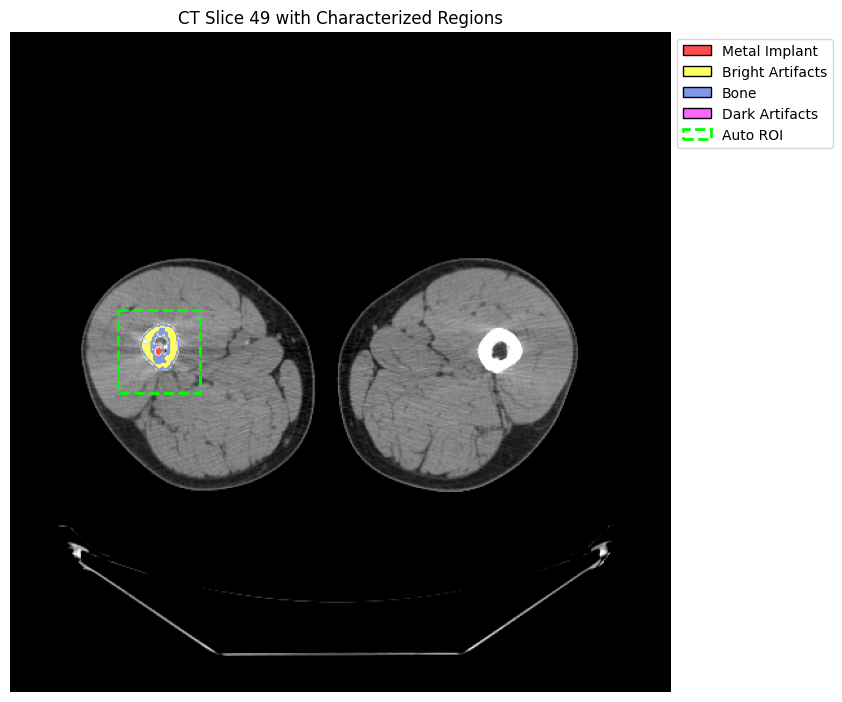


--- Generating IVHs for each characterized region on this slice ---


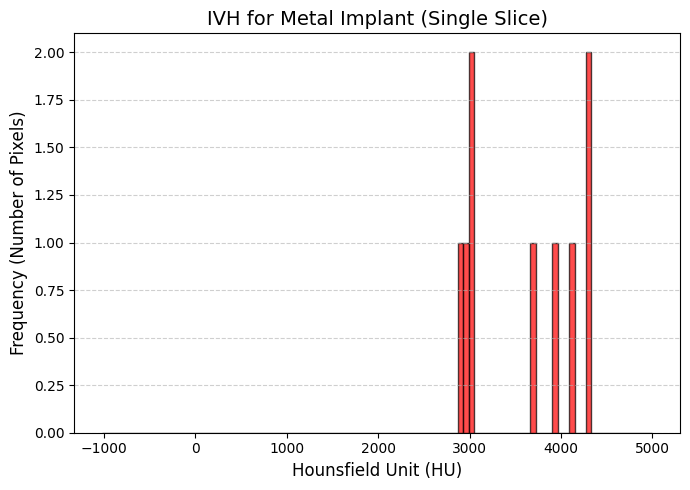

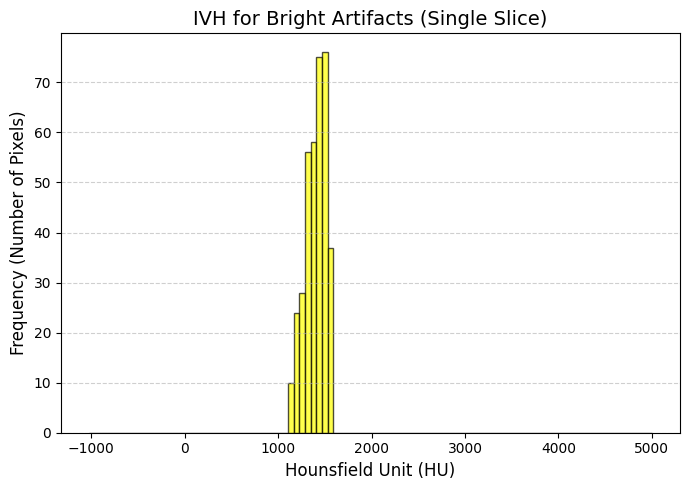

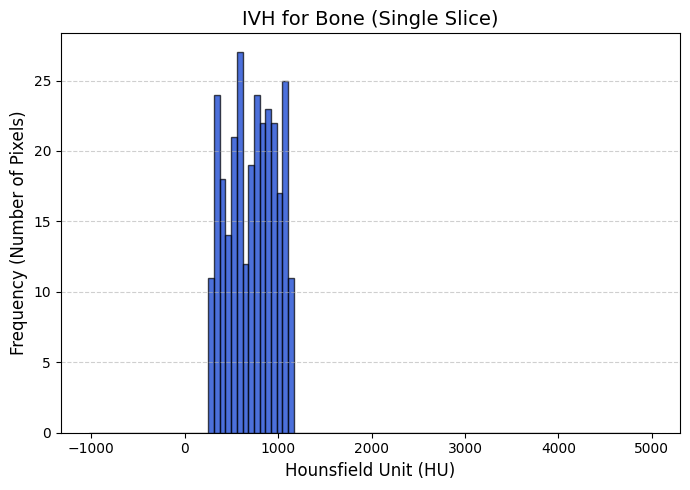

No HU values to plot for Dark Artifacts.


In [37]:
# --- Main Execution Example ---
if __name__ == "__main__":
    # --- IMPORTANT: REPLACE THESE WITH YOUR ACTUAL PATHS ---
    ct_series_directory = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"
    rtstruct_file_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 RSTRUCT\2.16.840.1.114362.1.12177026.23360333229.708561731.777.13.dcm"

    # --- DEFINE THE NAMES OF YOUR IMPLANT CONTOURS ---
    IMPLANT_CONTOUR_NAMES = ["metal", "implant", "femur", "acetabular", "ball", "socket", "ROI-1", "ROI-2", 'moon', 'main']

    if not os.path.isdir(ct_series_directory):
        print(f"Error: CT series directory not found at '{ct_series_directory}'. Please update the path.")
    elif not os.path.isfile(rtstruct_file_path):
        print(f"Error: RTSTRUCT file not found at '{rtstruct_file_path}'. Please update the path.")
    else:
        print(f"Loading CT series from: {ct_series_directory}")
        ct_hu_volume, ct_spatial_meta = load_dicom_series_to_hu(ct_series_directory)

        if ct_hu_volume is None:
            print("Failed to load CT volume. Exiting.")
        else:
            print(f"CT Volume loaded with shape: {ct_hu_volume.shape}")
            slice_to_analyze = 49

            # --- Generate metal mask from RTSTRUCT ---
            print(f"\nGenerating metal mask from RTSTRUCT for slice {slice_to_analyze}...")
            rtstruct_metal_mask = create_metal_mask_from_rtstruct(
                rtstruct_path=rtstruct_file_path,
                ct_spatial_meta=ct_spatial_meta,
                slice_index=slice_to_analyze,
                implant_roi_names=IMPLANT_CONTOUR_NAMES
            )

            # --- Define your HU thresholds/ranges ---
            # These now serve as fallbacks if auto-detection fails
            bright_artifact_range_vals = [(1000, 3000)]
            bone_range_vals = (300, 1300)
            artifact_margin_pixels_val = 30

            print(f"\nVisualizing and characterizing regions for slice {slice_to_analyze}...")
            visualize_implant_artifacts_and_tissues(
                ct_hu_volume=ct_hu_volume,
                slice_index=slice_to_analyze,
                metal_mask=rtstruct_metal_mask,
                bright_artifact_hu_ranges=bright_artifact_range_vals,
                bone_hu_range=bone_range_vals,
                artifact_roi_margin_pixels=artifact_margin_pixels_val,
                auto_find_dark_range=True,
                auto_find_bright_range=True # <-- ENABLE THE NEW FEATURE
            )